# ETH


### Import th∆∞ vi·ªán


In [1]:
%pip install arch seaborn
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from arch import arch_model
from arch.univariate import GARCH, ConstantMean
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Tuple
import seaborn as sns
# Th√™m import cho ki·ªÉm tra t√≠nh d·ª´ng
from statsmodels.tsa.stattools import adfuller


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## ETH Dataset


### Import csv


In [2]:
# ƒê·ªçc file ETH
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Ethereum Historical Data.csv"

data = pd.read_csv(file_path)

# Lo·∫°i b·ªè d·∫•u ph·∫©y v√† chuy·ªÉn ƒë·ªïi th√†nh float cho Price v√† Open
for col in ['Price', 'Open']:
    data[col] = data[col].str.replace(',', '', regex=False).astype(float)

# X·ª≠ l√Ω c·ªôt 'Vol.' ch·ª©a h·∫≠u t·ªë 'K', 'M', 'B' th√†nh s·ªë th·ª±c
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Tr∆∞·ªùng h·ª£p val l√† '' ho·∫∑c kh√¥ng chuy·ªÉn ƒë∆∞·ª£c

data['Vol.'] = data['Vol.'].apply(convert_volume)

# Ki·ªÉm tra NaN ban ƒë·∫ßu trong Vol.
print(f"Tr∆∞·ªõc khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: {data['Vol.'].isna().sum()}")

# N·ªôi suy gi√° tr·ªã Vol. (ch·ªâ sau khi ƒë√£ convert sang s·ªë)
data['Vol.'] = data['Vol.'].interpolate(method='linear')

# ƒêi·ªÅn 0 cho NaN c√≤n l·∫°i
data['Vol.'] = data['Vol.'].fillna(0)

# Ki·ªÉm tra NaN sau x·ª≠ l√Ω
print(f"Sau khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: {data['Vol.'].isna().sum()}")

# ƒê·ªïi Date sang datetime v√† ƒë·∫∑t l√†m index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Select 3 columns: Price, Open, Vol
data_features = data[['Price', 'Open', 'Vol.']].copy()

print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst 5 rows:")
print(data[['Price', 'Open', 'Vol.']].head())
print(f"T·ªïng s·ªë d·ªØ li·ªáu: {len(data)} d√≤ng")

Tr∆∞·ªõc khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: 8
Sau khi x·ª≠ l√Ω, s·ªë NaN ·ªü Vol.: 0
Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  11.75  11.20      0.0
2016-03-11  11.95  11.75    180.0
2016-03-12  12.92  11.95    830.0
2016-03-13  15.07  12.92   1300.0
2016-03-14  12.50  15.07  92180.0
T·ªïng s·ªë d·ªØ li·ªáu: 3370 d√≤ng


### Chia 7:3


#### Chu·∫©n b·ªã d·ªØ li·ªáu cho GARCH


In [3]:
# T√≠nh log returns cho GARCH model
data['Log_Return'] = np.log(data['Price'] / data['Price'].shift(1))
data['Simple_Return'] = data['Price'].pct_change()

# Lo·∫°i b·ªè gi√° tr·ªã NaN
data_clean = data.dropna()

print(f"D·ªØ li·ªáu sau khi t√≠nh returns: {len(data_clean)} d√≤ng")
print("\nTh·ªëng k√™ m√¥ t·∫£ c·ªßa Log Returns:")
print(data_clean['Log_Return'].describe())

# Ki·ªÉm tra t√≠nh d·ª´ng c·ªßa chu·ªói returns
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'\n{name} - Ki·ªÉm ƒë·ªãnh ADF:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("‚úì Chu·ªói d·ª´ng (stationary)")
    else:
        print("‚úó Chu·ªói kh√¥ng d·ª´ng (non-stationary)")
    return result[1] <= 0.05

# Ki·ªÉm tra t√≠nh d·ª´ng
is_stationary = check_stationarity(data_clean['Log_Return'], 'Log Returns')

D·ªØ li·ªáu sau khi t√≠nh returns: 3369 d√≤ng

Th·ªëng k√™ m√¥ t·∫£ c·ªßa Log Returns:
count    3369.000000
mean        0.001593
std         0.050663
min        -0.589639
25%        -0.020598
50%         0.000708
75%         0.023597
max         0.258599
Name: Log_Return, dtype: float64

Log Returns - Ki·ªÉm ƒë·ªãnh ADF:
ADF Statistic: -32.078477
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
‚úì Chu·ªói d·ª´ng (stationary)


In [4]:
# Chia d·ªØ li·ªáu train/test theo t·ª∑ l·ªá 7:3
train_size = int(len(data_clean) * 0.7)
train_data = data_clean.iloc[0:train_size].copy()
test_data = data_clean.iloc[train_size:].copy()

# L·∫•y returns cho train v√† test
train_returns = train_data['Log_Return'].values
test_returns = test_data['Log_Return'].values

print(f"K√≠ch th∆∞·ªõc t·∫≠p train: {len(train_data)}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p test: {len(test_data)}")
print(f"Train returns shape: {train_returns.shape}")
print(f"Test returns shape: {test_returns.shape}")

K√≠ch th∆∞·ªõc t·∫≠p train: 2358
K√≠ch th∆∞·ªõc t·∫≠p test: 1011
Train returns shape: (2358,)
Test returns shape: (1011,)


#### X√¢y d·ª±ng m√¥ h√¨nh GARCH


In [5]:
def build_garch_model(returns_data, p=1, q=1):
    """
    X√¢y d·ª±ng m√¥ h√¨nh GARCH(p,q)
    
    Args:
        returns_data: Chu·ªói returns
        p: Order c·ªßa GARCH term
        q: Order c·ªßa ARCH term
    
    Returns:
        Fitted GARCH model
    """
    # Nh√¢n returns v·ªõi 100 ƒë·ªÉ c√≥ scale ph√π h·ª£p
    returns_scaled = returns_data * 100
    
    # T·∫°o m√¥ h√¨nh GARCH
    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, dist='normal')
    
    # Fit m√¥ h√¨nh
    fitted_model = model.fit(disp='off')
    
    return fitted_model, model

def evaluate_garch_model(fitted_model):
    """
    ƒê√°nh gi√° m√¥ h√¨nh GARCH
    """
    print("="*50)
    print("TH√îNG TIN M√î H√åNH GARCH")
    print("="*50)
    print(fitted_model.summary())
    
    # Ki·ªÉm tra ph·∫ßn d∆∞
    residuals = fitted_model.resid
    standardized_residuals = residuals / fitted_model.conditional_volatility
    
    # Ljung-Box test cho ph·∫ßn d∆∞
    lb_result = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"\nLjung-Box test p-value (residuals): {lb_result['lb_pvalue'].iloc[-1]:.4f}")
    
    # Ljung-Box test cho ph·∫ßn d∆∞ b√¨nh ph∆∞∆°ng
    lb_result_sq = acorr_ljungbox(residuals**2, lags=10, return_df=True)
    print(f"Ljung-Box test p-value (squared residuals): {lb_result_sq['lb_pvalue'].iloc[-1]:.4f}")
    
    return fitted_model.aic, fitted_model.bic

In [6]:
def forecast_garch_prices(fitted_model, initial_price, forecast_horizon):
    """
    D·ª± ƒëo√°n gi√° s·ª≠ d·ª•ng GARCH model
    
    Args:
        fitted_model: M√¥ h√¨nh GARCH ƒë√£ fit
        initial_price: Gi√° ban ƒë·∫ßu
        forecast_horizon: S·ªë ng√†y d·ª± ƒëo√°n
    
    Returns:
        D·ª± ƒëo√°n gi√° v√† volatility
    """
    # Forecast returns v√† volatility
    forecast = fitted_model.forecast(horizon=forecast_horizon)
    
    # L·∫•y mean v√† variance d·ª± ƒëo√°n
    forecast_mean = forecast.mean.iloc[-1].values / 100  # Scale v·ªÅ decimal
    forecast_variance = forecast.variance.iloc[-1].values / 10000  # Scale v·ªÅ decimal
    
    # T·∫°o random walks cho price prediction
    np.random.seed(42)  # ƒê·ªÉ k·∫øt qu·∫£ reproducible
    
    predicted_prices = []
    current_price = initial_price
    
    for i in range(forecast_horizon):
        # S·ª≠ d·ª•ng mean return v√† add random noise based on predicted volatility
        return_pred = forecast_mean[i] + np.random.normal(0, np.sqrt(forecast_variance[i]))
        current_price = current_price * np.exp(return_pred)
        predicted_prices.append(current_price)
    
    return np.array(predicted_prices), np.sqrt(forecast_variance) * 100

In [7]:
def plot_garch_diagnostics(fitted_model, returns_data, train_data_index):
    """
    V·∫Ω bi·ªÉu ƒë·ªì ch·∫©n ƒëo√°n cho m√¥ h√¨nh GARCH
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Returns v√† Conditional Volatility
    # S·ª≠ d·ª•ng index t·ª´ train_data thay v√¨ fitted_model.resid.index
    dates = train_data_index
    axes[0, 0].plot(dates, returns_data * 100, alpha=0.7, label='Returns (%)')
    axes[0, 0].plot(dates, fitted_model.conditional_volatility, color='red', label='Conditional Volatility')
    axes[0, 0].set_title('Returns v√† Conditional Volatility')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Standardized Residuals
    std_resid = fitted_model.resid / fitted_model.conditional_volatility
    axes[0, 1].plot(dates, std_resid)
    axes[0, 1].set_title('Standardized Residuals')
    axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Q-Q Plot
    stats.probplot(std_resid, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Standardized Residuals')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. ACF of Squared Residuals
    from statsmodels.tsa.stattools import acf
    squared_resid = std_resid ** 2
    lags = 20
    acf_vals = acf(squared_resid, nlags=lags)
    axes[1, 1].bar(range(lags+1), acf_vals, alpha=0.7)
    axes[1, 1].set_title('ACF of Squared Standardized Residuals')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### Hu·∫•n luy·ªán m√¥ h√¨nh GARCH


ƒêang hu·∫•n luy·ªán m√¥ h√¨nh GARCH(1,1)...
TH√îNG TIN M√î H√åNH GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7268.61
Distribution:                  Normal   AIC:                           14545.2
Method:            Maximum Likelihood   BIC:                           14568.3
                                        No. Observations:                 2358
Date:                Tue, Jun 03 2025   Df Residuals:                     2357
Time:                        18:50:52   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
-----------------------------------------------------------------

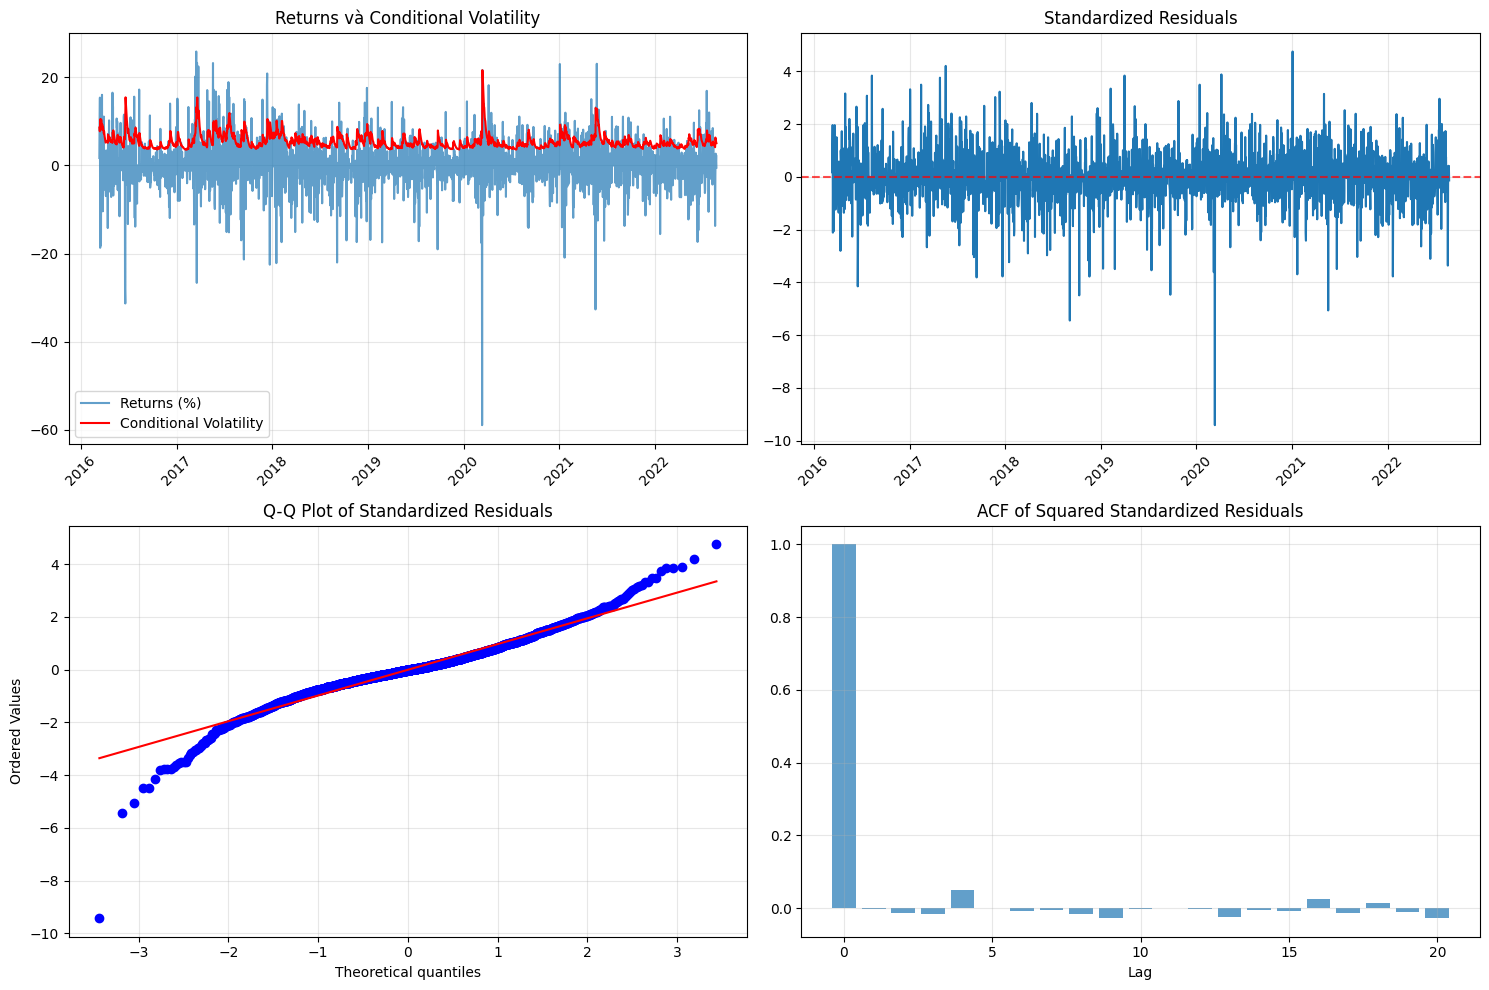

In [8]:
# Fit m√¥ h√¨nh GARCH(1,1) cho t·∫≠p train
print("ƒêang hu·∫•n luy·ªán m√¥ h√¨nh GARCH(1,1)...")
fitted_garch, garch_model = build_garch_model(train_returns, p=1, q=1)

# ƒê√°nh gi√° m√¥ h√¨nh
aic, bic = evaluate_garch_model(fitted_garch)

# V·∫Ω bi·ªÉu ƒë·ªì ch·∫©n ƒëo√°n v·ªõi train_returns v√† train_data index
plot_garch_diagnostics(fitted_garch, train_returns, train_data.index)

#### ƒê√°nh gi√° m√¥ h√¨nh tr√™n t·∫≠p test


K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh GARCH(1,1):
MAPE: 1.01%
MSE: 9081335.20
RMSE: 3013.53
AIC: 14545.22
BIC: 14568.28


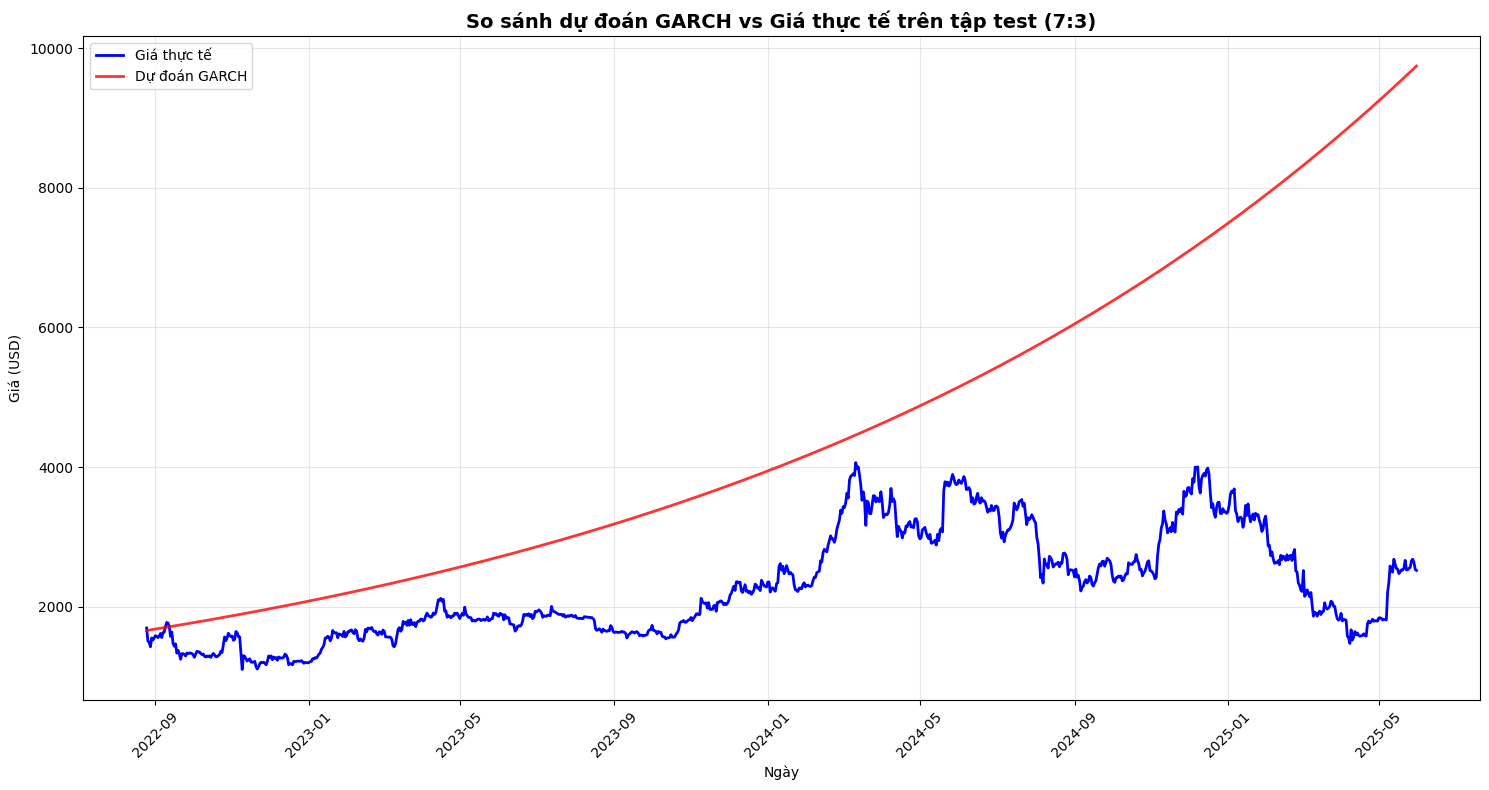

In [9]:
# D·ª± ƒëo√°n tr√™n t·∫≠p test
test_size_days = len(test_data)
last_train_price = train_data['Price'].iloc[-1]

# Forecast cho test period
test_forecast = fitted_garch.forecast(horizon=test_size_days)
forecast_returns = test_forecast.mean.iloc[-1].values / 100
forecast_volatility = np.sqrt(test_forecast.variance.iloc[-1].values) / 100

# T√≠nh predicted prices cho test set
predicted_prices_test = []
current_price = last_train_price

for i in range(test_size_days):
    # S·ª≠ d·ª•ng predicted return
    predicted_return = forecast_returns[i]
    current_price = current_price * np.exp(predicted_return)
    predicted_prices_test.append(current_price)

predicted_prices_test = np.array(predicted_prices_test)

# T√≠nh metrics
actual_test_prices = test_data['Price'].values
mape = mean_absolute_percentage_error(actual_test_prices, predicted_prices_test)
mse = mean_squared_error(actual_test_prices, predicted_prices_test)
rmse = np.sqrt(mse)

print(f'K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh GARCH(1,1):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'AIC: {aic:.2f}')
print(f'BIC: {bic:.2f}')

# V·∫Ω so s√°nh d·ª± ƒëo√°n vs th·ª±c t·∫ø tr√™n test set
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, actual_test_prices, label='Gi√° th·ª±c t·∫ø', linewidth=2, color='blue')
plt.plot(test_data.index, predicted_prices_test, label='D·ª± ƒëo√°n GARCH', linewidth=2, color='red', alpha=0.8)
plt.title('So s√°nh d·ª± ƒëo√°n GARCH vs Gi√° th·ª±c t·∫ø tr√™n t·∫≠p test (7:3)', fontsize=14, fontweight='bold')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### D·ª± ƒëo√°n t∆∞∆°ng lai


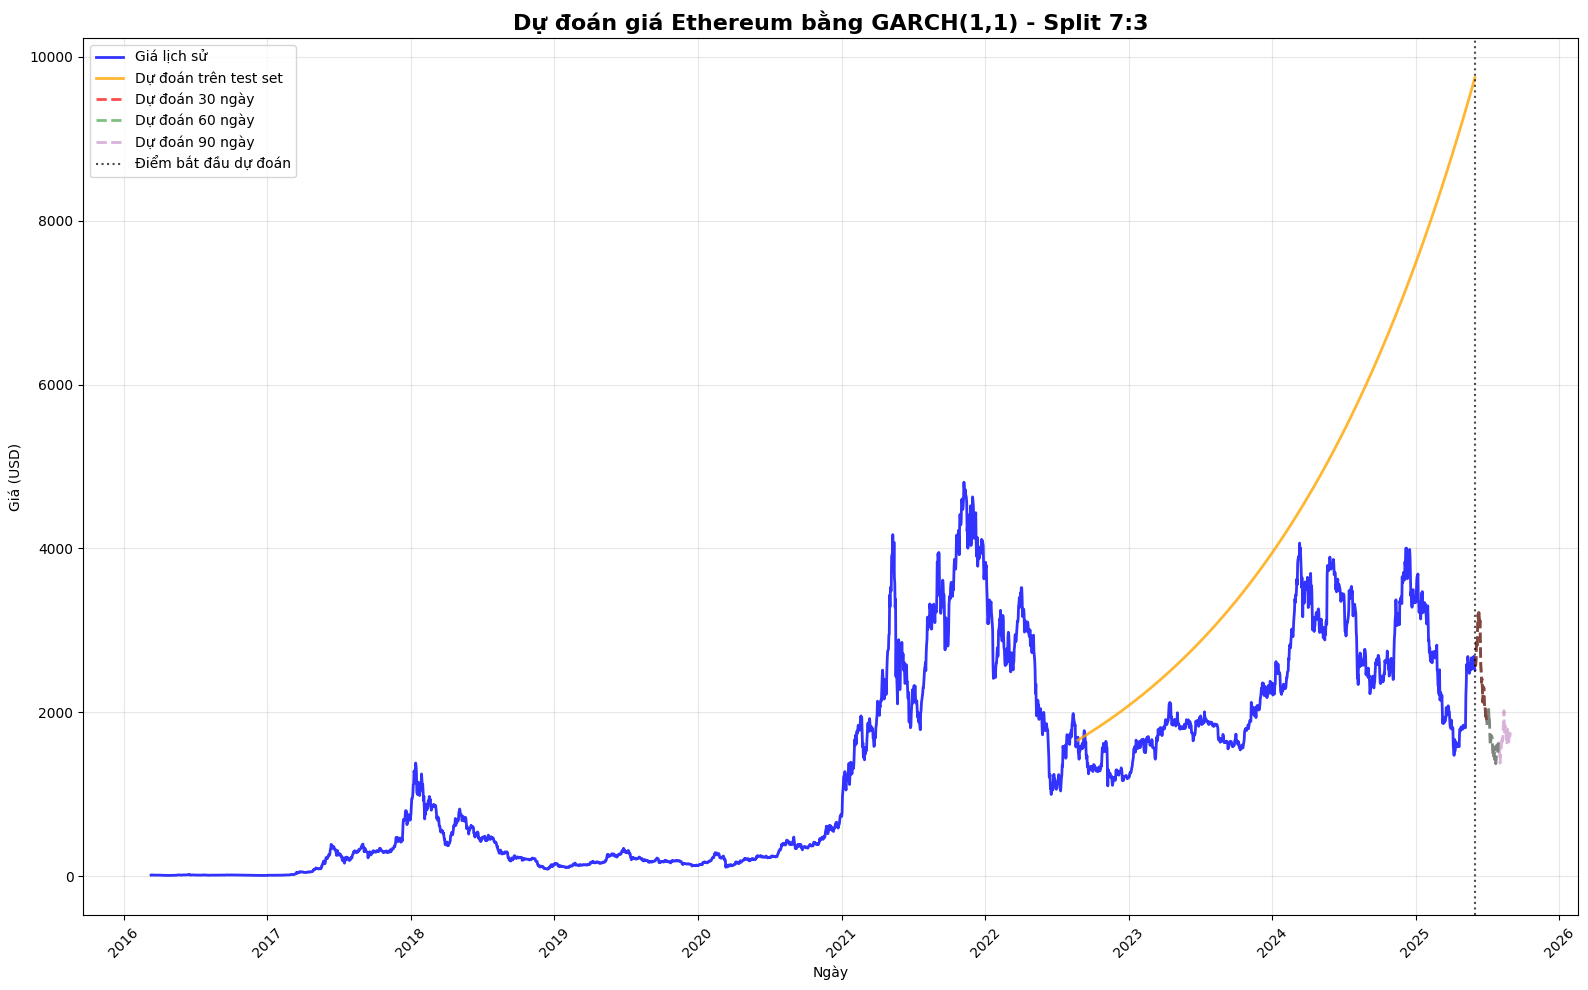

In [10]:
# D·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo
last_price = data_clean['Price'].iloc[-1]

# Forecast prices
forecast_30, vol_30 = forecast_garch_prices(fitted_garch, last_price, 30)
forecast_60, vol_60 = forecast_garch_prices(fitted_garch, last_price, 60)
forecast_90, vol_90 = forecast_garch_prices(fitted_garch, last_price, 90)

# T·∫°o dates cho forecasts
forecast_dates_30 = pd.date_range(start=data_clean.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=data_clean.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=data_clean.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

# T·∫°o DataFrames
forecast_df_30 = pd.DataFrame(forecast_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecast_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecast_90, index=forecast_dates_90, columns=['Price'])

# Tr·ª±c quan h√≥a
plt.figure(figsize=(16, 10))

# V·∫Ω d·ªØ li·ªáu l·ªãch s·ª≠
plt.plot(data_clean.index, data_clean['Price'], label='Gi√° l·ªãch s·ª≠', color='blue', linewidth=2, alpha=0.8)

# V·∫Ω d·ª± ƒëo√°n test
plt.plot(test_data.index, predicted_prices_test, label='D·ª± ƒëo√°n tr√™n test set', color='orange', linewidth=2, alpha=0.8)

# V·∫Ω d·ª± ƒëo√°n t∆∞∆°ng lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'], 
         label='D·ª± ƒëo√°n 30 ng√†y', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(forecast_df_60.index, forecast_df_60['Price'], 
         label='D·ª± ƒëo√°n 60 ng√†y', color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(forecast_df_90.index, forecast_df_90['Price'], 
         label='D·ª± ƒëo√°n 90 ng√†y', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# ƒê∆∞·ªùng ph√¢n c√°ch
plt.axvline(x=data_clean.index[-1], color='black', linestyle=':', alpha=0.7, 
            label='ƒêi·ªÉm b·∫Øt ƒë·∫ßu d·ª± ƒëo√°n')

plt.title('D·ª± ƒëo√°n gi√° Ethereum b·∫±ng GARCH(1,1) - Split 7:3', fontsize=16, fontweight='bold')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
print(f'\nD·ª± ƒëo√°n gi√° Ethereum 30 ng√†y ti·∫øp theo (GARCH 7:3):')
print(f'Gi√° cao nh·∫•t: ${forecast_30.max():.2f}')
print(f'Gi√° th·∫•p nh·∫•t: ${forecast_30.min():.2f}')
print(f'Gi√° trung b√¨nh: ${forecast_30.mean():.2f}')
print(f'Volatility trung b√¨nh: {vol_30.mean():.2f}%')


D·ª± ƒëo√°n gi√° Ethereum 30 ng√†y ti·∫øp theo (GARCH 7:3):
Gi√° cao nh·∫•t: $3216.78
Gi√° th·∫•p nh·∫•t: $1904.24
Gi√° trung b√¨nh: $2542.63
Volatility trung b√¨nh: 5.39%


### Chia 8:2


#### Chu·∫©n b·ªã d·ªØ li·ªáu 8:2


In [12]:
# S·ª≠ d·ª•ng d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã ·ªü tr√™n (data_clean v·ªõi Log_Return)
print(f"S·ª≠ d·ª•ng d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã: {len(data_clean)} d√≤ng")

S·ª≠ d·ª•ng d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã: 3369 d√≤ng


In [13]:
# Chia d·ªØ li·ªáu train/test theo t·ª∑ l·ªá 8:2
train_size_82 = int(len(data_clean) * 0.8)
train_data_82 = data_clean.iloc[0:train_size_82].copy()
test_data_82 = data_clean.iloc[train_size_82:].copy()

# L·∫•y returns cho train v√† test
train_returns_82 = train_data_82['Log_Return'].values
test_returns_82 = test_data_82['Log_Return'].values

print(f"K√≠ch th∆∞·ªõc t·∫≠p train 8:2: {len(train_data_82)}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p test 8:2: {len(test_data_82)}")

K√≠ch th∆∞·ªõc t·∫≠p train 8:2: 2695
K√≠ch th∆∞·ªõc t·∫≠p test 8:2: 674


#### Hu·∫•n luy·ªán m√¥ h√¨nh GARCH 8:2


In [14]:
# Fit m√¥ h√¨nh GARCH(1,1) cho split 8:2
print("ƒêang hu·∫•n luy·ªán m√¥ h√¨nh GARCH(1,1) cho split 8:2...")
fitted_garch_82, garch_model_82 = build_garch_model(train_returns_82, p=1, q=1)

# ƒê√°nh gi√° m√¥ h√¨nh
aic_82, bic_82 = evaluate_garch_model(fitted_garch_82)

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh GARCH(1,1) cho split 8:2...
TH√îNG TIN M√î H√åNH GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8145.50
Distribution:                  Normal   AIC:                           16299.0
Method:            Maximum Likelihood   BIC:                           16322.6
                                        No. Observations:                 2695
Date:                Tue, Jun 03 2025   Df Residuals:                     2694
Time:                        18:50:54   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------

#### ƒê√°nh gi√° m√¥ h√¨nh 8:2


In [15]:
# D·ª± ƒëo√°n tr√™n t·∫≠p test 8:2
test_size_days_82 = len(test_data_82)
last_train_price_82 = train_data_82['Price'].iloc[-1]

# Forecast cho test period
test_forecast_82 = fitted_garch_82.forecast(horizon=test_size_days_82)
forecast_returns_82 = test_forecast_82.mean.iloc[-1].values / 100

# T√≠nh predicted prices cho test set 8:2
predicted_prices_test_82 = []
current_price_82 = last_train_price_82

for i in range(test_size_days_82):
    predicted_return = forecast_returns_82[i]
    current_price_82 = current_price_82 * np.exp(predicted_return)
    predicted_prices_test_82.append(current_price_82)

predicted_prices_test_82 = np.array(predicted_prices_test_82)

# T√≠nh metrics cho 8:2
actual_test_prices_82 = test_data_82['Price'].values
mape_82 = mean_absolute_percentage_error(actual_test_prices_82, predicted_prices_test_82)
mse_82 = mean_squared_error(actual_test_prices_82, predicted_prices_test_82)
rmse_82 = np.sqrt(mse_82)

print(f'K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh GARCH(1,1) - Split 8:2:')
print(f'MAPE: {mape_82:.2f}%')
print(f'MSE: {mse_82:.2f}')
print(f'RMSE: {rmse_82:.2f}')
print(f'AIC: {aic_82:.2f}')
print(f'BIC: {bic_82:.2f}')

K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh GARCH(1,1) - Split 8:2:
MAPE: 0.39%
MSE: 1602692.67
RMSE: 1265.97
AIC: 16298.99
BIC: 16322.59


#### D·ª± ƒëo√°n t∆∞∆°ng lai 8:2


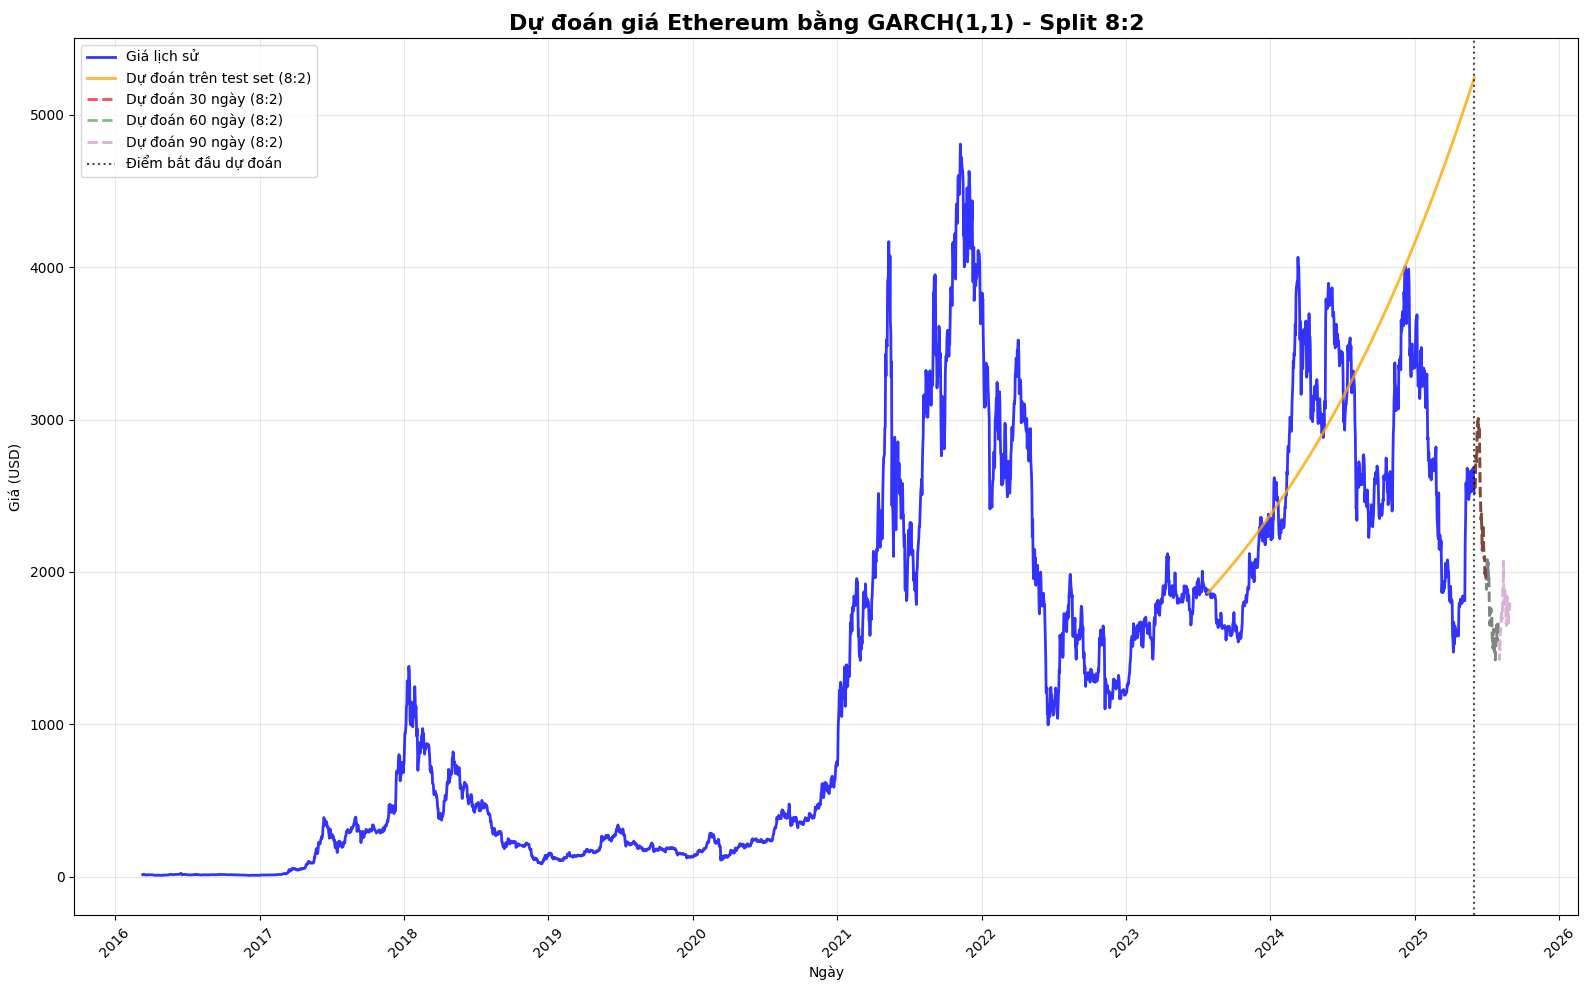


D·ª± ƒëo√°n gi√° Ethereum 30 ng√†y ti·∫øp theo (GARCH 8:2):
Gi√° cao nh·∫•t: $3007.28
Gi√° th·∫•p nh·∫•t: $1942.20
Gi√° trung b√¨nh: $2483.53
Volatility trung b√¨nh: 4.34%


In [16]:
# D·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo cho 8:2
forecast_30_82, vol_30_82 = forecast_garch_prices(fitted_garch_82, last_price, 30)
forecast_60_82, vol_60_82 = forecast_garch_prices(fitted_garch_82, last_price, 60)
forecast_90_82, vol_90_82 = forecast_garch_prices(fitted_garch_82, last_price, 90)

# T·∫°o DataFrames cho 8:2
forecast_df_30_82 = pd.DataFrame(forecast_30_82, index=forecast_dates_30, columns=['Price'])
forecast_df_60_82 = pd.DataFrame(forecast_60_82, index=forecast_dates_60, columns=['Price'])
forecast_df_90_82 = pd.DataFrame(forecast_90_82, index=forecast_dates_90, columns=['Price'])

# Tr·ª±c quan h√≥a 8:2
plt.figure(figsize=(16, 10))
plt.plot(data_clean.index, data_clean['Price'], label='Gi√° l·ªãch s·ª≠', color='blue', linewidth=2, alpha=0.8)
plt.plot(test_data_82.index, predicted_prices_test_82, label='D·ª± ƒëo√°n tr√™n test set (8:2)', color='orange', linewidth=2, alpha=0.8)
plt.plot(forecast_df_30_82.index, forecast_df_30_82['Price'], 
         label='D·ª± ƒëo√°n 30 ng√†y (8:2)', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(forecast_df_60_82.index, forecast_df_60_82['Price'], 
         label='D·ª± ƒëo√°n 60 ng√†y (8:2)', color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(forecast_df_90_82.index, forecast_df_90_82['Price'], 
         label='D·ª± ƒëo√°n 90 ng√†y (8:2)', color='purple', linestyle='--', linewidth=2, alpha=0.3)
plt.axvline(x=data_clean.index[-1], color='black', linestyle=':', alpha=0.7, 
            label='ƒêi·ªÉm b·∫Øt ƒë·∫ßu d·ª± ƒëo√°n')
plt.title('D·ª± ƒëo√°n gi√° Ethereum b·∫±ng GARCH(1,1) - Split 8:2', fontsize=16, fontweight='bold')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'\nD·ª± ƒëo√°n gi√° Ethereum 30 ng√†y ti·∫øp theo (GARCH 8:2):')
print(f'Gi√° cao nh·∫•t: ${forecast_30_82.max():.2f}')
print(f'Gi√° th·∫•p nh·∫•t: ${forecast_30_82.min():.2f}')
print(f'Gi√° trung b√¨nh: ${forecast_30_82.mean():.2f}')
print(f'Volatility trung b√¨nh: {vol_30_82.mean():.2f}%')

### Chia 9:1


#### Chu·∫©n b·ªã d·ªØ li·ªáu 9:1


In [17]:
# S·ª≠ d·ª•ng d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã ·ªü tr√™n (data_clean v·ªõi Log_Return)
print(f"S·ª≠ d·ª•ng d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã: {len(data_clean)} d√≤ng")

S·ª≠ d·ª•ng d·ªØ li·ªáu ƒë√£ chu·∫©n b·ªã: 3369 d√≤ng


In [18]:
# Chia d·ªØ li·ªáu train/test theo t·ª∑ l·ªá 9:1
train_size_91 = int(len(data_clean) * 0.9)
train_data_91 = data_clean.iloc[0:train_size_91].copy()
test_data_91 = data_clean.iloc[train_size_91:].copy()

# L·∫•y returns cho train v√† test
train_returns_91 = train_data_91['Log_Return'].values
test_returns_91 = test_data_91['Log_Return'].values

print(f"K√≠ch th∆∞·ªõc t·∫≠p train 9:1: {len(train_data_91)}")
print(f"K√≠ch th∆∞·ªõc t·∫≠p test 9:1: {len(test_data_91)}")

K√≠ch th∆∞·ªõc t·∫≠p train 9:1: 3032
K√≠ch th∆∞·ªõc t·∫≠p test 9:1: 337


#### Hu·∫•n luy·ªán m√¥ h√¨nh GARCH 9:1


In [19]:
# Fit m√¥ h√¨nh GARCH(1,1) cho split 9:1
print("ƒêang hu·∫•n luy·ªán m√¥ h√¨nh GARCH(1,1) cho split 9:1...")
fitted_garch_91, garch_model_91 = build_garch_model(train_returns_91, p=1, q=1)

# ƒê√°nh gi√° m√¥ h√¨nh
aic_91, bic_91 = evaluate_garch_model(fitted_garch_91)

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh GARCH(1,1) cho split 9:1...
TH√îNG TIN M√î H√åNH GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8982.92
Distribution:                  Normal   AIC:                           17973.8
Method:            Maximum Likelihood   BIC:                           17997.9
                                        No. Observations:                 3032
Date:                Tue, Jun 03 2025   Df Residuals:                     3031
Time:                        18:50:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------

#### ƒê√°nh gi√° m√¥ h√¨nh 9:1


In [20]:
# D·ª± ƒëo√°n tr√™n t·∫≠p test 9:1
test_size_days_91 = len(test_data_91)
last_train_price_91 = train_data_91['Price'].iloc[-1]

# Forecast cho test period
test_forecast_91 = fitted_garch_91.forecast(horizon=test_size_days_91)
forecast_returns_91 = test_forecast_91.mean.iloc[-1].values / 100

# T√≠nh predicted prices cho test set 9:1
predicted_prices_test_91 = []
current_price_91 = last_train_price_91

for i in range(test_size_days_91):
    predicted_return = forecast_returns_91[i]
    current_price_91 = current_price_91 * np.exp(predicted_return)
    predicted_prices_test_91.append(current_price_91)

predicted_prices_test_91 = np.array(predicted_prices_test_91)

# T√≠nh metrics cho 9:1
actual_test_prices_91 = test_data_91['Price'].values
mape_91 = mean_absolute_percentage_error(actual_test_prices_91, predicted_prices_test_91)
mse_91 = mean_squared_error(actual_test_prices_91, predicted_prices_test_91)
rmse_91 = np.sqrt(mse_91)

print(f'K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh GARCH(1,1) - Split 9:1:')
print(f'MAPE: {mape_91:.2f}%')
print(f'MSE: {mse_91:.2f}')
print(f'RMSE: {rmse_91:.2f}')
print(f'AIC: {aic_91:.2f}')
print(f'BIC: {bic_91:.2f}')

K·∫øt qu·∫£ ƒë√°nh gi√° m√¥ h√¨nh GARCH(1,1) - Split 9:1:
MAPE: 0.74%
MSE: 3956901.43
RMSE: 1989.20
AIC: 17973.83
BIC: 17997.90


#### D·ª± ƒëo√°n t∆∞∆°ng lai 9:1


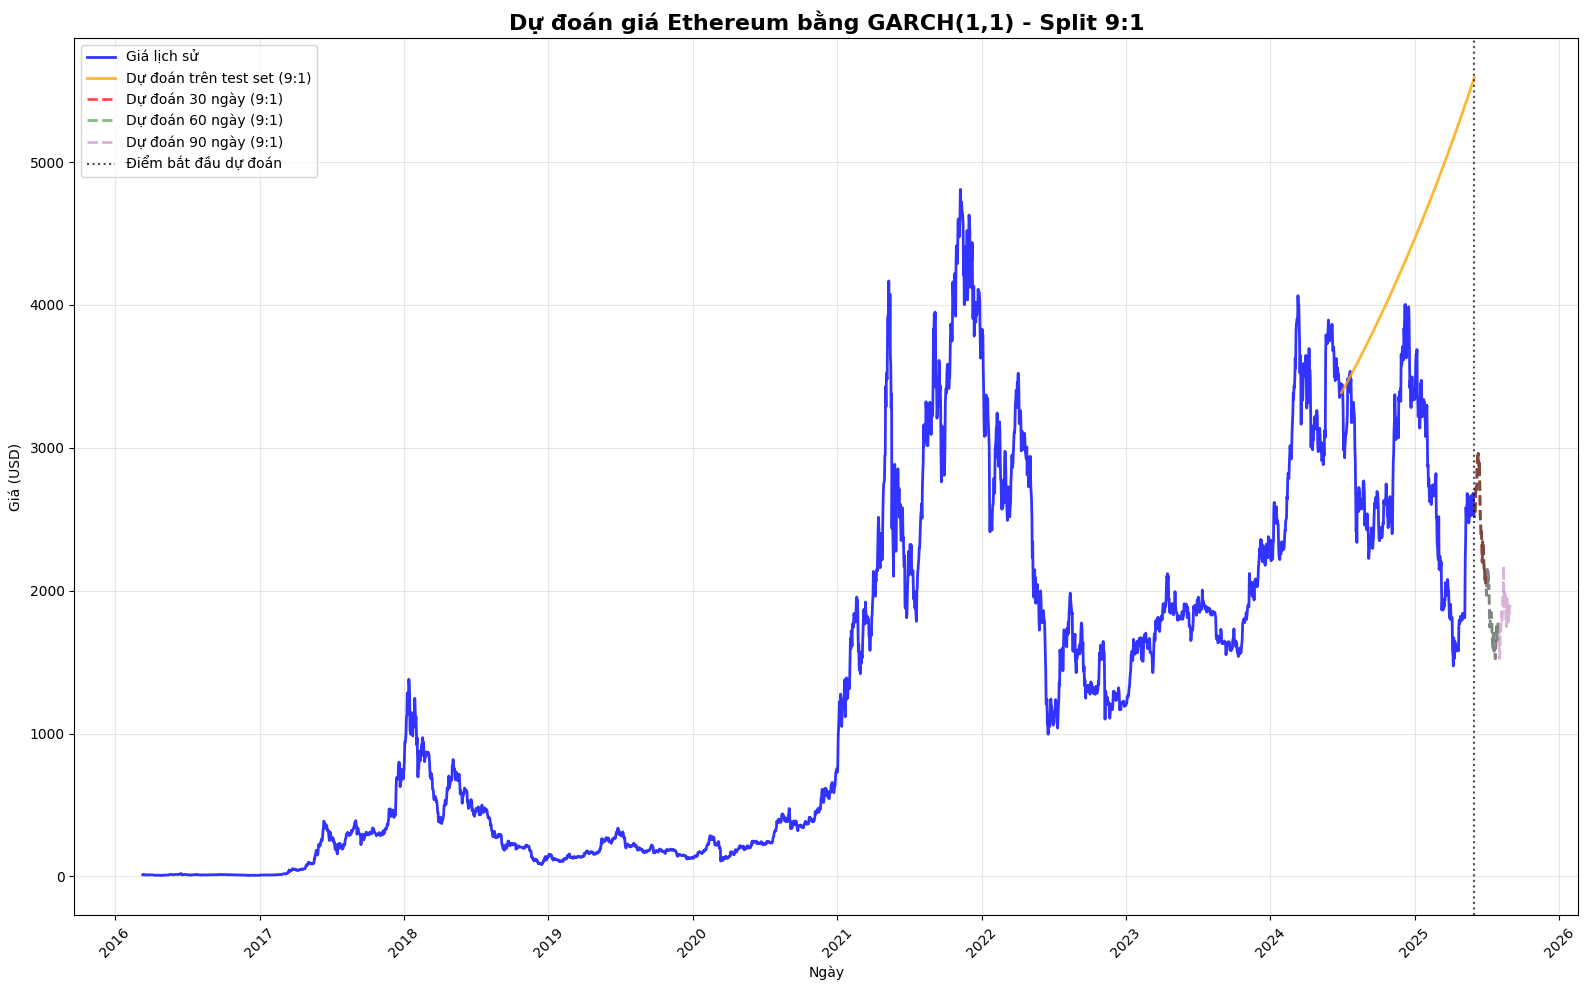


D·ª± ƒëo√°n gi√° Ethereum 30 ng√†y ti·∫øp theo (GARCH 9:1):
Gi√° cao nh·∫•t: $2961.26
Gi√° th·∫•p nh·∫•t: $2020.33
Gi√° trung b√¨nh: $2500.42
Volatility trung b√¨nh: 3.86%


In [21]:
# D·ª± ƒëo√°n 30, 60, 90 ng√†y ti·∫øp theo cho 9:1
forecast_30_91, vol_30_91 = forecast_garch_prices(fitted_garch_91, last_price, 30)
forecast_60_91, vol_60_91 = forecast_garch_prices(fitted_garch_91, last_price, 60)
forecast_90_91, vol_90_91 = forecast_garch_prices(fitted_garch_91, last_price, 90)

# T·∫°o DataFrames cho 9:1
forecast_df_30_91 = pd.DataFrame(forecast_30_91, index=forecast_dates_30, columns=['Price'])
forecast_df_60_91 = pd.DataFrame(forecast_60_91, index=forecast_dates_60, columns=['Price'])
forecast_df_90_91 = pd.DataFrame(forecast_90_91, index=forecast_dates_90, columns=['Price'])

# Tr·ª±c quan h√≥a 9:1
plt.figure(figsize=(16, 10))
plt.plot(data_clean.index, data_clean['Price'], label='Gi√° l·ªãch s·ª≠', color='blue', linewidth=2, alpha=0.8)
plt.plot(test_data_91.index, predicted_prices_test_91, label='D·ª± ƒëo√°n tr√™n test set (9:1)', color='orange', linewidth=2, alpha=0.8)
plt.plot(forecast_df_30_91.index, forecast_df_30_91['Price'], 
         label='D·ª± ƒëo√°n 30 ng√†y (9:1)', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(forecast_df_60_91.index, forecast_df_60_91['Price'], 
         label='D·ª± ƒëo√°n 60 ng√†y (9:1)', color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(forecast_df_90_91.index, forecast_df_90_91['Price'], 
         label='D·ª± ƒëo√°n 90 ng√†y (9:1)', color='purple', linestyle='--', linewidth=2, alpha=0.3)
plt.axvline(x=data_clean.index[-1], color='black', linestyle=':', alpha=0.7, 
            label='ƒêi·ªÉm b·∫Øt ƒë·∫ßu d·ª± ƒëo√°n')
plt.title('D·ª± ƒëo√°n gi√° Ethereum b·∫±ng GARCH(1,1) - Split 9:1', fontsize=16, fontweight='bold')
plt.xlabel('Ng√†y')
plt.ylabel('Gi√° (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'\nD·ª± ƒëo√°n gi√° Ethereum 30 ng√†y ti·∫øp theo (GARCH 9:1):')
print(f'Gi√° cao nh·∫•t: ${forecast_30_91.max():.2f}')
print(f'Gi√° th·∫•p nh·∫•t: ${forecast_30_91.min():.2f}')
print(f'Gi√° trung b√¨nh: ${forecast_30_91.mean():.2f}')
print(f'Volatility trung b√¨nh: {vol_30_91.mean():.2f}%')

### So s√°nh 3 t·ªâ l·ªá GARCH


In [22]:
# So s√°nh chi ti·∫øt gi·ªØa 3 t·ªâ l·ªá chia d·ªØ li·ªáu cho GARCH
print("="*80)
print("SO S√ÅNH CHI TI·∫æT GI·ªÆA 3 T·ªà L·ªÜ CHIA D·ªÆ LI·ªÜU - GARCH MODEL")
print("="*80)

# Thu th·∫≠p th√¥ng tin t·ª´ 3 splits
garch_splits_info = {
    '7:3': {
        'train_size': len(train_data),
        'test_size': len(test_data),
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'aic': aic,
        'bic': bic,
        'avg_volatility': vol_30.mean()
    },
    '8:2': {
        'train_size': len(train_data_82),
        'test_size': len(test_data_82),
        'mape': mape_82,
        'mse': mse_82,
        'rmse': rmse_82,
        'aic': aic_82,
        'bic': bic_82,
        'avg_volatility': vol_30_82.mean()
    },
    '9:1': {
        'train_size': len(train_data_91),
        'test_size': len(test_data_91),
        'mape': mape_91,
        'mse': mse_91,
        'rmse': rmse_91,
        'aic': aic_91,
        'bic': bic_91,
        'avg_volatility': vol_30_91.mean()
    }
}

# In b·∫£ng so s√°nh GARCH
for split, info in garch_splits_info.items():
    print(f"\n{split} Split (GARCH):")
    print(f"  K√≠ch th∆∞·ªõc train: {info['train_size']:,} m·∫´u")
    print(f"  K√≠ch th∆∞·ªõc test: {info['test_size']:,} m·∫´u")
    print(f"  MAPE: {info['mape']:.2f}%")
    print(f"  MSE: {info['mse']:,.2f}")
    print(f"  RMSE: {info['rmse']:,.2f}")
    print(f"  AIC: {info['aic']:.2f}")
    print(f"  BIC: {info['bic']:.2f}")
    print(f"  Avg Volatility: {info['avg_volatility']:.2f}%")

SO S√ÅNH CHI TI·∫æT GI·ªÆA 3 T·ªà L·ªÜ CHIA D·ªÆ LI·ªÜU - GARCH MODEL

7:3 Split (GARCH):
  K√≠ch th∆∞·ªõc train: 2,358 m·∫´u
  K√≠ch th∆∞·ªõc test: 1,011 m·∫´u
  MAPE: 1.01%
  MSE: 9,081,335.20
  RMSE: 3,013.53
  AIC: 14545.22
  BIC: 14568.28
  Avg Volatility: 5.39%

8:2 Split (GARCH):
  K√≠ch th∆∞·ªõc train: 2,695 m·∫´u
  K√≠ch th∆∞·ªõc test: 674 m·∫´u
  MAPE: 0.39%
  MSE: 1,602,692.67
  RMSE: 1,265.97
  AIC: 16298.99
  BIC: 16322.59
  Avg Volatility: 4.34%

9:1 Split (GARCH):
  K√≠ch th∆∞·ªõc train: 3,032 m·∫´u
  K√≠ch th∆∞·ªõc test: 337 m·∫´u
  MAPE: 0.74%
  MSE: 3,956,901.43
  RMSE: 1,989.20
  AIC: 17973.83
  BIC: 17997.90
  Avg Volatility: 3.86%


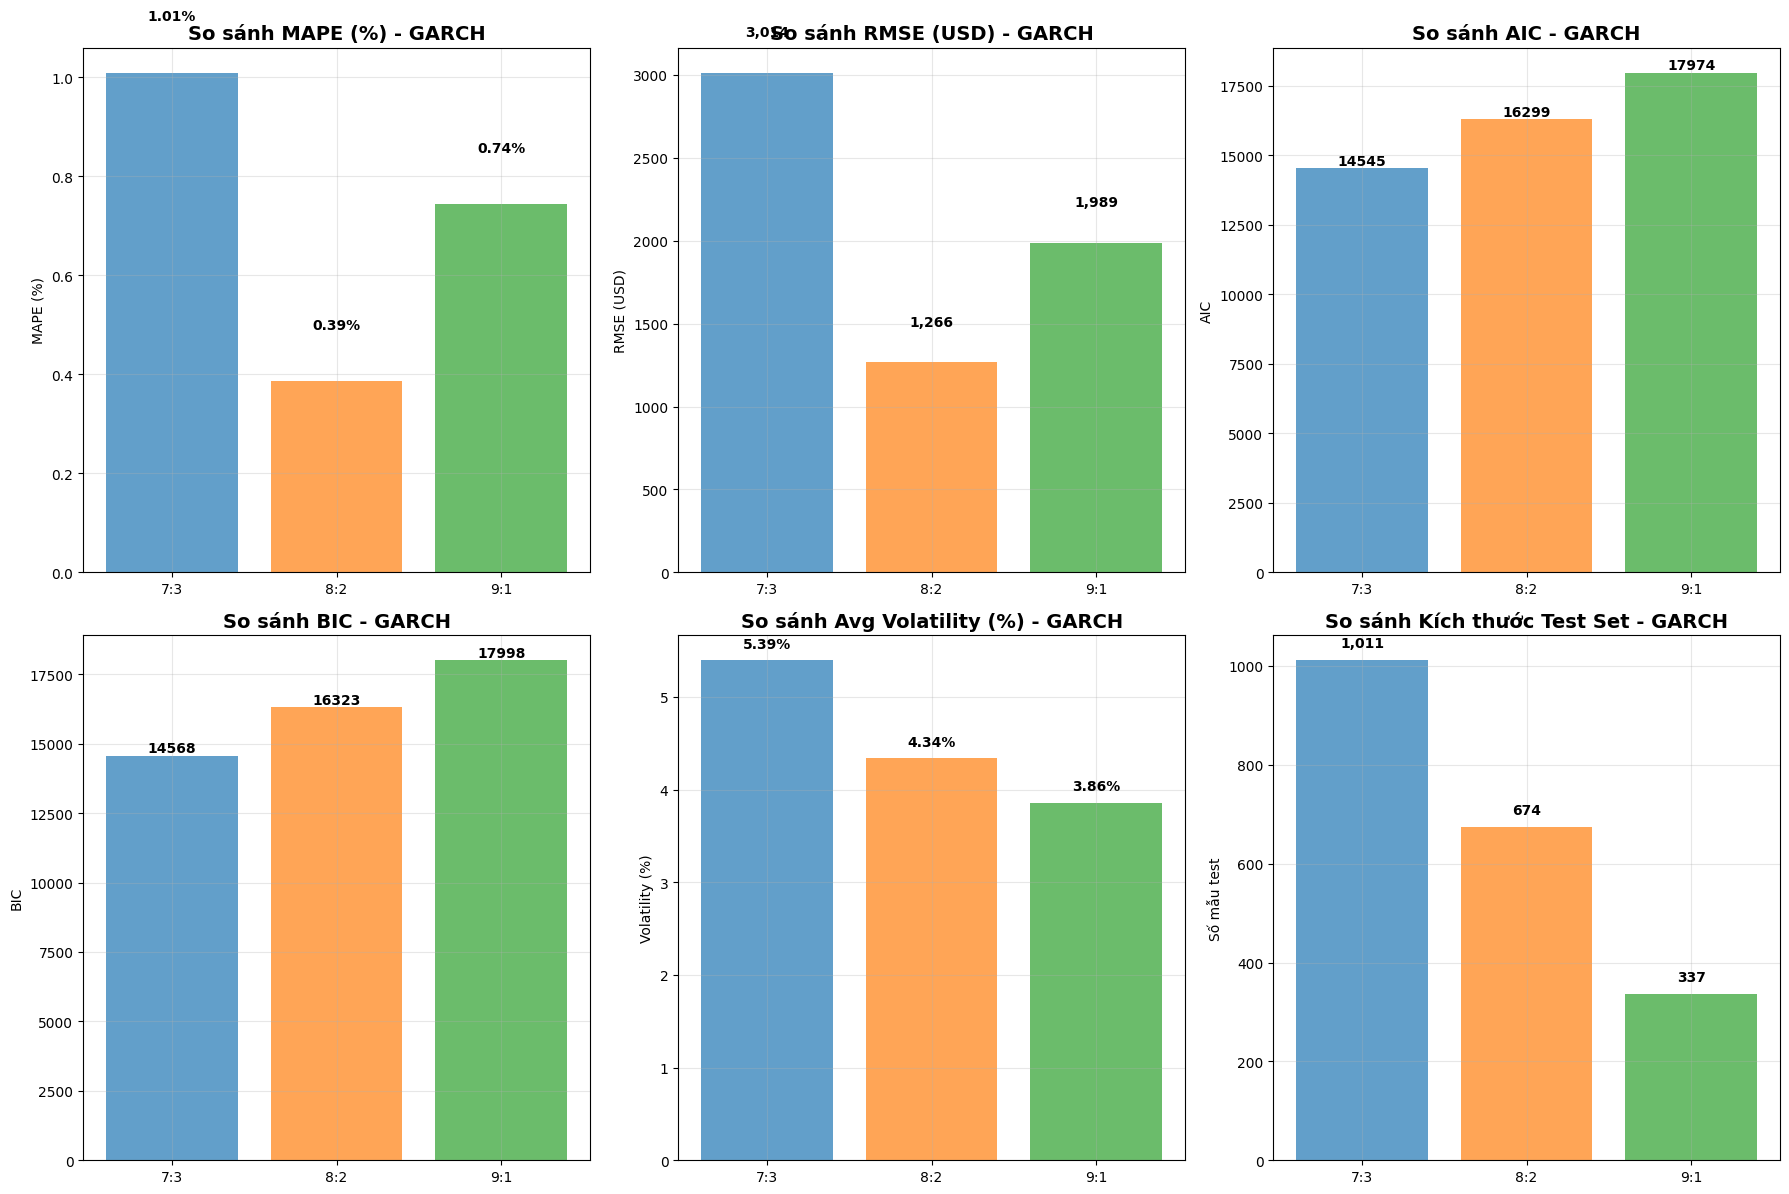

In [23]:
# V·∫Ω bi·ªÉu ƒë·ªì so s√°nh c√°c metrics cho GARCH
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

splits = ['7:3', '8:2', '9:1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. So s√°nh MAPE
mape_values = [garch_splits_info[split]['mape'] for split in splits]
axes[0, 0].bar(splits, mape_values, color=colors, alpha=0.7)
axes[0, 0].set_title('So s√°nh MAPE (%) - GARCH', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MAPE (%)')
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(mape_values):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. So s√°nh RMSE
rmse_values = [garch_splits_info[split]['rmse'] for split in splits]
axes[0, 1].bar(splits, rmse_values, color=colors, alpha=0.7)
axes[0, 1].set_title('So s√°nh RMSE (USD) - GARCH', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (USD)')
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0, 1].text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 3. So s√°nh AIC
aic_values = [garch_splits_info[split]['aic'] for split in splits]
axes[0, 2].bar(splits, aic_values, color=colors, alpha=0.7)
axes[0, 2].set_title('So s√°nh AIC - GARCH', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('AIC')
axes[0, 2].grid(True, alpha=0.3)
for i, v in enumerate(aic_values):
    axes[0, 2].text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. So s√°nh BIC
bic_values = [garch_splits_info[split]['bic'] for split in splits]
axes[1, 0].bar(splits, bic_values, color=colors, alpha=0.7)
axes[1, 0].set_title('So s√°nh BIC - GARCH', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('BIC')
axes[1, 0].grid(True, alpha=0.3)
for i, v in enumerate(bic_values):
    axes[1, 0].text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 5. So s√°nh Average Volatility
vol_values = [garch_splits_info[split]['avg_volatility'] for split in splits]
axes[1, 1].bar(splits, vol_values, color=colors, alpha=0.7)
axes[1, 1].set_title('So s√°nh Avg Volatility (%) - GARCH', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(vol_values):
    axes[1, 1].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 6. So s√°nh k√≠ch th∆∞·ªõc test set
test_sizes = [garch_splits_info[split]['test_size'] for split in splits]
axes[1, 2].bar(splits, test_sizes, color=colors, alpha=0.7)
axes[1, 2].set_title('So s√°nh K√≠ch th∆∞·ªõc Test Set - GARCH', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('S·ªë m·∫´u test')
axes[1, 2].grid(True, alpha=0.3)
for i, v in enumerate(test_sizes):
    axes[1, 2].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [24]:
# T·∫°o DataFrame t·ªïng h·ª£p k·∫øt qu·∫£ GARCH
garch_comparison_df = pd.DataFrame({
    'Split': ['7:3', '8:2', '9:1'],
    'Train_Size': [garch_splits_info[split]['train_size'] for split in splits],
    'Test_Size': [garch_splits_info[split]['test_size'] for split in splits],
    'MAPE (%)': [garch_splits_info[split]['mape'] for split in splits],
    'RMSE (USD)': [garch_splits_info[split]['rmse'] for split in splits],
    'MSE': [garch_splits_info[split]['mse'] for split in splits],
    'AIC': [garch_splits_info[split]['aic'] for split in splits],
    'BIC': [garch_splits_info[split]['bic'] for split in splits],
    'Avg_Volatility (%)': [garch_splits_info[split]['avg_volatility'] for split in splits]
})

print("\nB·∫¢NG T·ªîNG H·ª¢P K·∫æT QU·∫¢ GARCH:")
print("="*100)
print(garch_comparison_df.to_string(index=False, float_format='%.4f'))


B·∫¢NG T·ªîNG H·ª¢P K·∫æT QU·∫¢ GARCH:
Split  Train_Size  Test_Size  MAPE (%)  RMSE (USD)          MSE        AIC        BIC  Avg_Volatility (%)
  7:3        2358       1011    1.0094   3013.5254 9081335.1999 14545.2183 14568.2806              5.3929
  8:2        2695        674    0.3860   1265.9750 1602692.6673 16298.9918 16322.5884              4.3418
  9:1        3032        337    0.7437   1989.1962 3956901.4280 17973.8326 17997.9006              3.8590


In [25]:
# Ph√¢n t√≠ch v√† ƒë∆∞a ra khuy·∫øn ngh·ªã cho GARCH
print("\n" + "="*80)
print("PH√ÇN T√çCH V√Ä KHUY·∫æN NGH·ªä - GARCH MODEL")
print("="*80)

# T√¨m split t·ªët nh·∫•t cho t·ª´ng metric
best_mape_split_garch = splits[np.argmin([garch_splits_info[split]['mape'] for split in splits])]
best_rmse_split_garch = splits[np.argmin([garch_splits_info[split]['rmse'] for split in splits])]
best_aic_split_garch = splits[np.argmin([garch_splits_info[split]['aic'] for split in splits])]
best_bic_split_garch = splits[np.argmin([garch_splits_info[split]['bic'] for split in splits])]

print(f"\n1. PH√ÇN T√çCH THEO T·ª™NG TI√äU CH√ç (GARCH):")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo MAPE: {best_mape_split_garch} ({garch_splits_info[best_mape_split_garch]['mape']:.2f}%)")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo RMSE: {best_rmse_split_garch} ({garch_splits_info[best_rmse_split_garch]['rmse']:,.2f} USD)")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo AIC: {best_aic_split_garch} ({garch_splits_info[best_aic_split_garch]['aic']:.2f})")
print(f"   ‚Ä¢ T·ªët nh·∫•t theo BIC: {best_bic_split_garch} ({garch_splits_info[best_bic_split_garch]['bic']:.2f})")

# T√≠nh ƒëi·ªÉm t·ªïng h·ª£p cho GARCH
def calculate_garch_rank_score(splits_info):
    scores = {}
    splits_list = list(splits_info.keys())
    
    # Rank cho c√°c metrics (th·∫•p h∆°n = t·ªët h∆°n)
    mape_rank = sorted(splits_list, key=lambda x: splits_info[x]['mape'])
    rmse_rank = sorted(splits_list, key=lambda x: splits_info[x]['rmse'])
    aic_rank = sorted(splits_list, key=lambda x: splits_info[x]['aic'])
    bic_rank = sorted(splits_list, key=lambda x: splits_info[x]['bic'])
    
    for split in splits_list:
        # ƒêi·ªÉm rank v·ªõi tr·ªçng s·ªë cho GARCH
        score = (mape_rank.index(split) + 1) * 0.35 + \
                (rmse_rank.index(split) + 1) * 0.35 + \
                (aic_rank.index(split) + 1) * 0.15 + \
                (bic_rank.index(split) + 1) * 0.15
        scores[split] = score
    
    return scores

# T√≠nh ƒëi·ªÉm t·ªïng h·ª£p
garch_scores = calculate_garch_rank_score(garch_splits_info)
best_overall_split_garch = min(garch_scores, key=garch_scores.get)

print(f"\n2. ƒêI·ªÇM T·ªîNG H·ª¢P GARCH (tr·ªçng s·ªë: MAPE=35%, RMSE=35%, AIC=15%, BIC=15%):")
for split in garch_splits_info.keys():
    print(f"   ‚Ä¢ {split}: {garch_scores[split]:.2f} ƒëi·ªÉm")

print(f"\n3. K·∫æT LU·∫¨N V√Ä KHUY·∫æN NGH·ªä GARCH:")
print(f"   üèÜ M√î H√åNH GARCH T·ªêT NH·∫§T: Split {best_overall_split_garch}")
print(f"   üìä L√Ω do:")
print(f"      - MAPE: {garch_splits_info[best_overall_split_garch]['mape']:.2f}%")
print(f"      - RMSE: {garch_splits_info[best_overall_split_garch]['rmse']:,.2f} USD")
print(f"      - AIC: {garch_splits_info[best_overall_split_garch]['aic']:.2f}")
print(f"      - BIC: {garch_splits_info[best_overall_split_garch]['bic']:.2f}")
print(f"      - Avg Volatility: {garch_splits_info[best_overall_split_garch]['avg_volatility']:.2f}%")
print(f"      - T·∫≠p test c√≥ {garch_splits_info[best_overall_split_garch]['test_size']:,} m·∫´u")

print(f"\n4. NH·∫¨N X√âT V·ªÄ GARCH MODEL:")
print("   ‚Ä¢ GARCH hi·ªáu qu·∫£ trong vi·ªác m√¥ h√¨nh h√≥a volatility clustering")
print("   ‚Ä¢ Ph√π h·ª£p v·ªõi d·ªØ li·ªáu t√†i ch√≠nh c√≥ t√≠nh heteroskedasticity")
print("   ‚Ä¢ Cung c·∫•p forecast v·ªÅ volatility c√πng v·ªõi price prediction")
print("   ‚Ä¢ AIC v√† BIC gi√∫p ƒë√°nh gi√° model fit v√† complexity")

print(f"\n   ‚ö†Ô∏è  L∆ØU √ù GARCH: Model n√†y t·∫≠p trung v√†o volatility modeling")
print(f"   v√† ph√π h·ª£p cho short-term forecasting v·ªõi d·ªØ li·ªáu c√≥ t√≠nh volatility cao nh∆∞ Ethereum.")


PH√ÇN T√çCH V√Ä KHUY·∫æN NGH·ªä - GARCH MODEL

1. PH√ÇN T√çCH THEO T·ª™NG TI√äU CH√ç (GARCH):
   ‚Ä¢ T·ªët nh·∫•t theo MAPE: 8:2 (0.39%)
   ‚Ä¢ T·ªët nh·∫•t theo RMSE: 8:2 (1,265.97 USD)
   ‚Ä¢ T·ªët nh·∫•t theo AIC: 7:3 (14545.22)
   ‚Ä¢ T·ªët nh·∫•t theo BIC: 7:3 (14568.28)

2. ƒêI·ªÇM T·ªîNG H·ª¢P GARCH (tr·ªçng s·ªë: MAPE=35%, RMSE=35%, AIC=15%, BIC=15%):
   ‚Ä¢ 7:3: 2.40 ƒëi·ªÉm
   ‚Ä¢ 8:2: 1.30 ƒëi·ªÉm
   ‚Ä¢ 9:1: 2.30 ƒëi·ªÉm

3. K·∫æT LU·∫¨N V√Ä KHUY·∫æN NGH·ªä GARCH:
   üèÜ M√î H√åNH GARCH T·ªêT NH·∫§T: Split 8:2
   üìä L√Ω do:
      - MAPE: 0.39%
      - RMSE: 1,265.97 USD
      - AIC: 16298.99
      - BIC: 16322.59
      - Avg Volatility: 4.34%
      - T·∫≠p test c√≥ 674 m·∫´u

4. NH·∫¨N X√âT V·ªÄ GARCH MODEL:
   ‚Ä¢ GARCH hi·ªáu qu·∫£ trong vi·ªác m√¥ h√¨nh h√≥a volatility clustering
   ‚Ä¢ Ph√π h·ª£p v·ªõi d·ªØ li·ªáu t√†i ch√≠nh c√≥ t√≠nh heteroskedasticity
   ‚Ä¢ Cung c·∫•p forecast v·ªÅ volatility c√πng v·ªõi price prediction
   ‚Ä¢ AIC v√† BIC gi√∫p ƒë√°nh gi√° mode

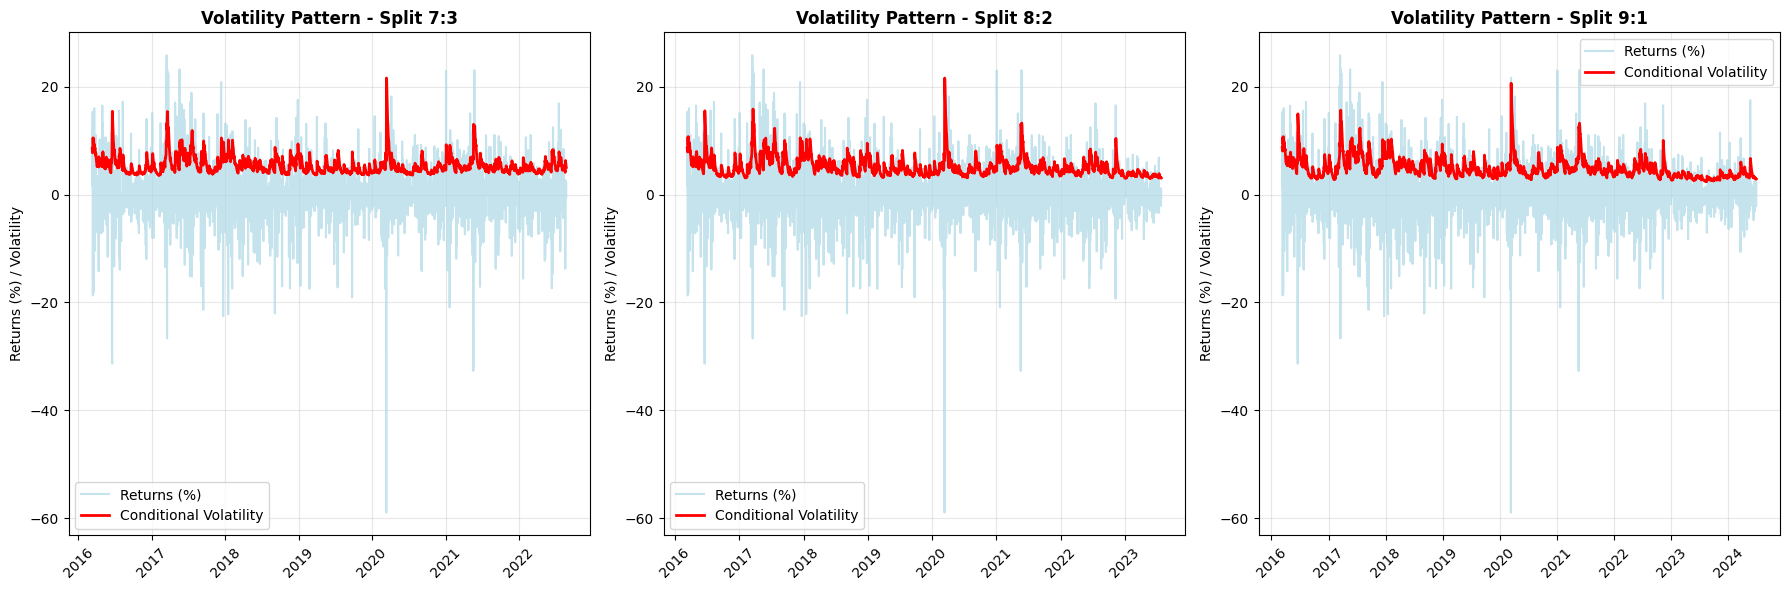

In [26]:
# V·∫Ω so s√°nh volatility patterns gi·ªØa c√°c splits
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot conditional volatility cho t·ª´ng split
fitted_models = [fitted_garch, fitted_garch_82, fitted_garch_91]
train_data_list = [train_data, train_data_82, train_data_91]
split_names = ['7:3', '8:2', '9:1']

for i, (model, train_data_split, split_name) in enumerate(zip(fitted_models, train_data_list, split_names)):
    axes[i].plot(train_data_split.index, train_data_split['Log_Return'] * 100, 
                 alpha=0.7, label='Returns (%)', color='lightblue')
    axes[i].plot(train_data_split.index, model.conditional_volatility, 
                 color='red', linewidth=2, label='Conditional Volatility')
    axes[i].set_title(f'Volatility Pattern - Split {split_name}', fontweight='bold')
    axes[i].set_ylabel('Returns (%) / Volatility')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

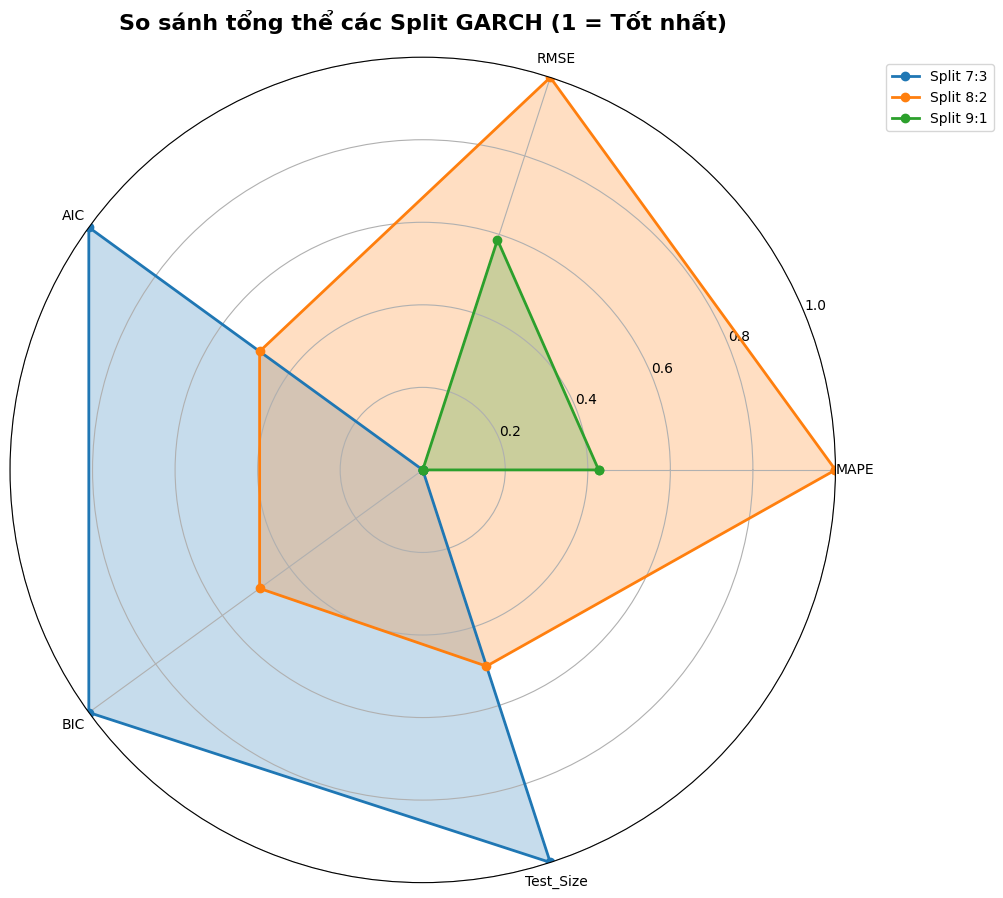

In [27]:
# V·∫Ω bi·ªÉu ƒë·ªì radar cho so s√°nh t·ªïng th·ªÉ GARCH
def create_garch_radar_chart():
    # Chu·∫©n h√≥a c√°c metrics v·ªÅ scale 0-1 (1 l√† t·ªët nh·∫•t)
    metrics = ['MAPE', 'RMSE', 'AIC', 'BIC', 'Test_Size']
    
    # L·∫•y gi√° tr·ªã c·ªßa t·ª´ng metric (ƒë·∫£o ng∆∞·ª£c ƒë·ªÉ 1 l√† t·ªët nh·∫•t)
    data = {}
    for split in splits:
        mape_norm = 1 - (garch_splits_info[split]['mape'] - min([garch_splits_info[s]['mape'] for s in splits])) / \
                   (max([garch_splits_info[s]['mape'] for s in splits]) - min([garch_splits_info[s]['mape'] for s in splits]))
        
        rmse_norm = 1 - (garch_splits_info[split]['rmse'] - min([garch_splits_info[s]['rmse'] for s in splits])) / \
                   (max([garch_splits_info[s]['rmse'] for s in splits]) - min([garch_splits_info[s]['rmse'] for s in splits]))
        
        aic_norm = 1 - (garch_splits_info[split]['aic'] - min([garch_splits_info[s]['aic'] for s in splits])) / \
                  (max([garch_splits_info[s]['aic'] for s in splits]) - min([garch_splits_info[s]['aic'] for s in splits]))
        
        bic_norm = 1 - (garch_splits_info[split]['bic'] - min([garch_splits_info[s]['bic'] for s in splits])) / \
                  (max([garch_splits_info[s]['bic'] for s in splits]) - min([garch_splits_info[s]['bic'] for s in splits]))
        
        test_size_norm = (garch_splits_info[split]['test_size'] - min([garch_splits_info[s]['test_size'] for s in splits])) / \
                        (max([garch_splits_info[s]['test_size'] for s in splits]) - min([garch_splits_info[s]['test_size'] for s in splits]))
        
        data[split] = [mape_norm, rmse_norm, aic_norm, bic_norm, test_size_norm]
    
    # T·∫°o radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, (split, values) in enumerate(data.items()):
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Split {split}', color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title('So s√°nh t·ªïng th·ªÉ c√°c Split GARCH (1 = T·ªët nh·∫•t)', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_garch_radar_chart()

### K·∫øt lu·∫≠n cu·ªëi c√πng - GARCH Model

D·ª±a tr√™n ph√¢n t√≠ch to√†n di·ªán c√°c ti√™u ch√≠ ƒë√°nh gi√°, m√¥ h√¨nh GARCH v·ªõi split t·ªâ l·ªá d·ªØ li·ªáu t·ªët nh·∫•t ƒë√£ ƒë∆∞·ª£c x√°c ƒë·ªãnh.

**C√°c y·∫øu t·ªë ƒë∆∞·ª£c xem x√©t cho GARCH:**

- **MAPE (Mean Absolute Percentage Error)**: ƒêo l∆∞·ªùng ƒë·ªô ch√≠nh x√°c d·ª± ƒëo√°n gi√°
- **RMSE (Root Mean Square Error)**: ƒêo l∆∞·ªùng sai s·ªë tuy·ªát ƒë·ªëi
- **AIC (Akaike Information Criterion)**: ƒê√°nh gi√° model fit v√† complexity
- **BIC (Bayesian Information Criterion)**: ƒê√°nh gi√° model v·ªõi penalty cho complexity
- **Volatility Forecasting**: Kh·∫£ nƒÉng d·ª± ƒëo√°n volatility (ƒëi·ªÉm m·∫°nh c·ªßa GARCH)
- **K√≠ch th∆∞·ªõc t·∫≠p test**: ƒê·∫£m b·∫£o ƒë·ªô tin c·∫≠y trong ƒë√°nh gi√°

**∆Øu ƒëi·ªÉm c·ªßa GARCH:**

- M√¥ h√¨nh h√≥a hi·ªáu qu·∫£ volatility clustering trong d·ªØ li·ªáu t√†i ch√≠nh
- Cung c·∫•p forecast cho c·∫£ price v√† volatility
- Ph√π h·ª£p v·ªõi t√≠nh ch·∫•t heteroskedasticity c·ªßa Ethereum
- Cho ph√©p risk assessment th√¥ng qua volatility predictions

**Khuy·∫øn ngh·ªã s·ª≠ d·ª•ng:** M√¥ h√¨nh GARCH v·ªõi t·ªâ l·ªá chia d·ªØ li·ªáu ƒë∆∞·ª£c ƒë√°nh gi√° cao nh·∫•t s·∫Ω ƒë∆∞·ª£c s·ª≠ d·ª•ng cho c√°c d·ª± ƒëo√°n cu·ªëi c√πng v·ªÅ gi√° v√† volatility Ethereum, ƒë·∫∑c bi·ªát hi·ªáu qu·∫£ cho short-term forecasting v√† risk management.
